# Otimizadores

Este notebook utiliza a rede inspirada na LeNet para classificar dígitos da base MNIST utilizando-se seis otimizadores diferentes


In [10]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float32'

In [11]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import time,sys
import numpy as np
import argparse
import cv2

import theano
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout

from keras.optimizers import SGD, RMSprop
from keras.callbacks import Callback
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
from sklearn import datasets

print 'Keras ', keras.__version__
print 'Theano', theano.__version__
print 'OpenCV', cv2.__version__
print 'Numpy ', np.__version__

Keras  1.2.0
Theano 0.8.2
OpenCV 3.1.0
Numpy  1.11.3


## MNIST database

In [12]:
sys.path.append('../src')
from keras.datasets import mnist
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 1, 28, 28) / 255.0
X_test = X_test.reshape(-1, 1, 28, 28) / 255.0

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print X_train.shape, X_test.shape
print y_train.shape, y_test.shape

(60000, 1, 28, 28) (10000, 1, 28, 28)
(60000, 10) (10000, 10)


## LeNet-like network

In [13]:

class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        
        # first set of CONV => RELU => POOL
        model.add(Convolution2D(20, 5, 5, border_mode="same", 
                                input_shape=(depth, height, width)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # second set of CONV => RELU => POOL
        model.add(Convolution2D(50, 5, 5, border_mode="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Dropout(0.5))
        
        # set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model


In [14]:
def train_network(optimizer, X_train, y_train, X_test, y_test, nepochs=50, ploss=0.25):
    print("[INFO] creating model...")
    model = LeNet.build(width=28, height=28, depth=1, classes=10)

    # History, checkpoint, earlystop, plot losses:
    my_big_callback = TrainingPlotter(n=1, patience=10)

    # initialize the optimizer and model
    print("[INFO] compiling model...")
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])    

    fig = plot.figure(figsize=(15,6))
    plot.ylim(0.0, ploss)
    plot.xlim(0, nepochs)
    plot.grid(True)

    print("[INFO] training...")
    try:
        histo2 = model.fit(X_train, y_train, batch_size=128, nb_epoch=nepochs, 
                           verbose=0, validation_split=0.33, callbacks=[my_big_callback])
    except KeyboardInterrupt:
        pass

    print("[INFO] evaluating...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))
    

## SGD with Momentum


[INFO] evaluating...
 9984/10000 [============================>.] - ETA: 0s

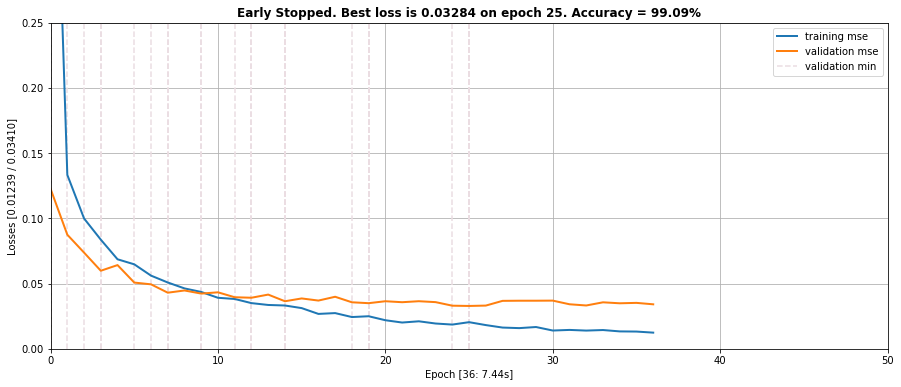

In [15]:
opt = SGD(lr=0.01, momentum=0.9)
train_network(opt, X_train, y_train, X_test, y_test)

## SGD with Nesterov momentum

[INFO] evaluating...
 9984/10000 [============================>.] - ETA: 0s

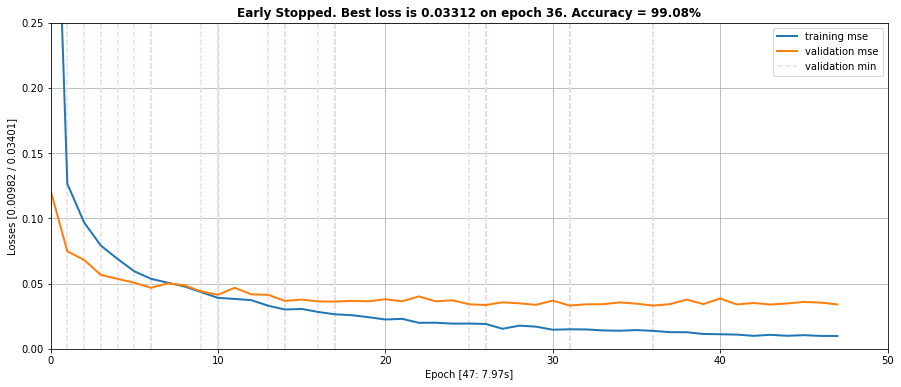

In [16]:
opt = SGD(lr=0.01, momentum=0.9, nesterov=True)
train_network(opt, X_train, y_train, X_test, y_test)

## SGD with learning rate decay

[INFO] evaluating...
10000/10000 [==============================] - 0s     

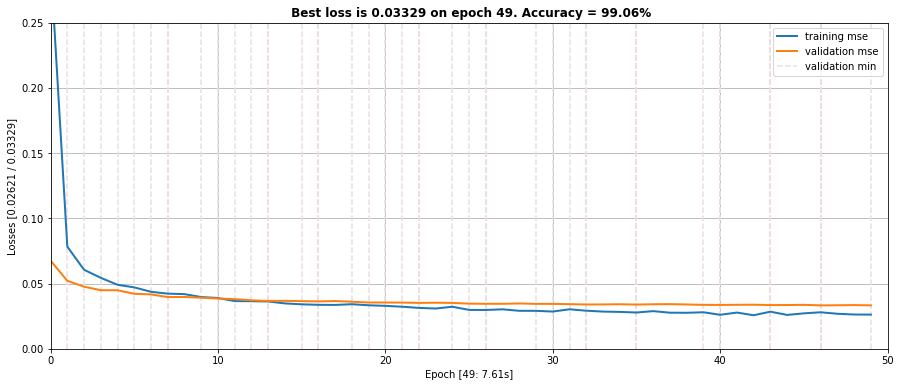

In [17]:
opt = SGD(lr=0.1, momentum=0.9, decay=0.01)
train_network(opt, X_train, y_train, X_test, y_test)

## RMSprop

[INFO] evaluating...
 9984/10000 [============================>.] - ETA: 0s

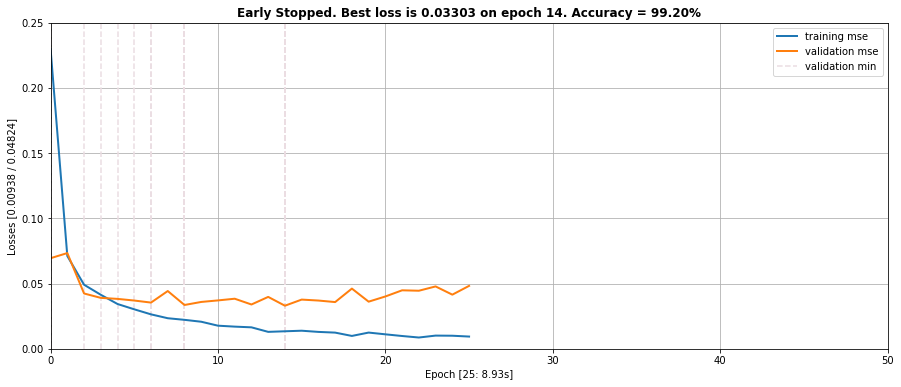

In [18]:
opt = RMSprop(lr=0.001)
train_network(opt, X_train, y_train, X_test, y_test)

## Adadelta

[INFO] evaluating...
 9984/10000 [============================>.] - ETA: 0s

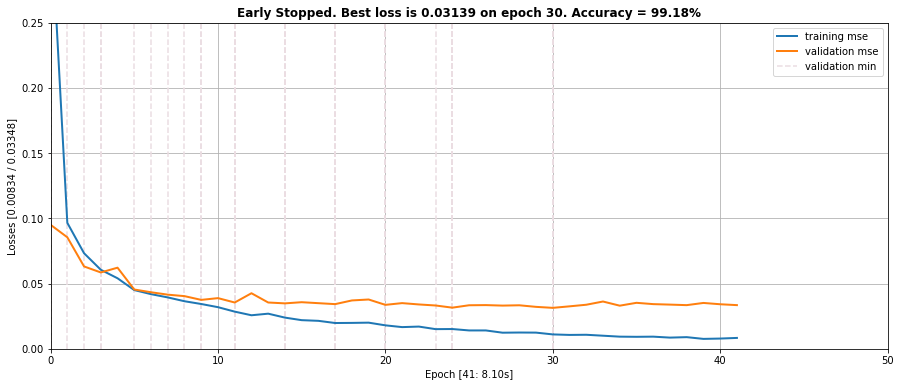

In [19]:
opt = 'adadelta'
train_network(opt, X_train, y_train, X_test, y_test)

## Adam

[INFO] evaluating...
 9984/10000 [============================>.] - ETA: 0s

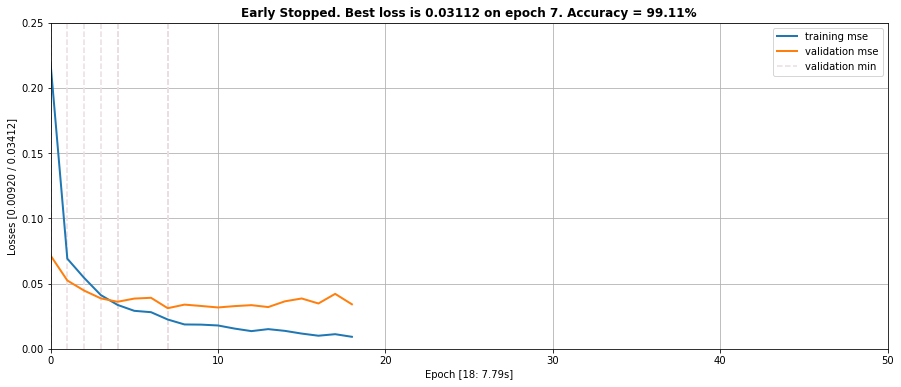

In [20]:
opt = 'adam'
train_network(opt, X_train, y_train, X_test, y_test)

## Aprendizados

